# Q&A Generative Chatbot

In [13]:
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

In [2]:
# Percorsi ai file JSON
annotations_train_path = '/home/pierluigi/Documents/datasets/Chatbot/VQA Annotations/v2_mscoco_train2014_annotations.json'
annotations_val_path = '/home/pierluigi/Documents/datasets/Chatbot/VQA Annotations/v2_mscoco_val2014_annotations.json'
questions_train_path = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Questions/v2_OpenEnded_mscoco_train2014_questions.json'
questions_val_path = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Questions/v2_OpenEnded_mscoco_val2014_questions.json'
images_train_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/train2014/'
images_val_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/val2014/'

In [3]:
# Carica i file di annotazioni e domande
with open(annotations_train_path, 'r') as f:
    annotations_train = json.load(f)

with open(annotations_val_path, 'r') as f:
    annotations_val = json.load(f)

with open(questions_train_path, 'r') as f:
    questions_train = json.load(f)

with open(questions_val_path, 'r') as f:
    questions_val = json.load(f)

I file JSON delle annotazioni e delle domande vengono caricati in variabili. 

create_df: Combina annotazioni e domande in un DataFrame, utilizzando question_id per unire domande e risposte. Crea inoltre il percorso dell’immagine usando image_id. Ogni riga contiene image_id, question_id, question, answer e image_path per accedere facilmente all'immagine.

In [4]:
# Crea DataFrame per le annotazioni e le domande
def create_df(annotations, questions):
    # Crea un dizionario delle domande con `question_id` come chiave
    questions_dict = {q['question_id']: q['question'] for q in questions['questions']}
    
    # Costruisci una lista di dizionari con tutte le informazioni necessarie
    data = []
    for ann in annotations['annotations']:
        image_id = ann['image_id']
        question_id = ann['question_id']
        question = questions_dict.get(question_id, "No question found")
        answer = ann['multiple_choice_answer']
        
        # Aggiungi l'informazione al dataset
        data.append({
            'image_id': image_id,
            'question_id': question_id,
            'question': question,
            'answer': answer,
            'image_path': os.path.join(images_train_dir if 'train' in annotations['info']['description'] else images_val_dir, f"COCO_train2014_{str(image_id).zfill(12)}.jpg")
        })
    
    return pd.DataFrame(data)

In [5]:
# Crea i DataFrame per il training e la validation
train_df = create_df(annotations_train, questions_train)
val_df = create_df(annotations_val, questions_val)

# Visualizza le prime righe del training DataFrame per confermare il caricamento
print("Training DataFrame Head:")
print(train_df.head())

# Visualizza le prime righe del validation DataFrame per confermare il caricamento
print("\nValidation DataFrame Head:")
print(val_df.head())

Training DataFrame Head:
   image_id  question_id                                     question  \
0    458752    458752000    What is this photo taken looking through?   
1    458752    458752001           What position is this man playing?   
2    458752    458752002             What color is the players shirt?   
3    458752    458752003  Is this man a professional baseball player?   
4    262146    262146000                      What color is the snow?   

    answer                                         image_path  
0      net  /home/pierluigi/Documents/datasets/Chatbot/VQA...  
1  pitcher  /home/pierluigi/Documents/datasets/Chatbot/VQA...  
2   orange  /home/pierluigi/Documents/datasets/Chatbot/VQA...  
3      yes  /home/pierluigi/Documents/datasets/Chatbot/VQA...  
4    white  /home/pierluigi/Documents/datasets/Chatbot/VQA...  

Validation DataFrame Head:
   image_id  question_id                                      question  \
0    262148    262148000                          

 Ora ogni riga contiene:

- image_id: per identificare l'immagine.
- question_id: per tenere traccia delle domande.
- question: la domanda completa.
- answer: la risposta principale alla domanda.
- image_path: il percorso dell’immagine associata, che potrai caricare per l’addestramento.

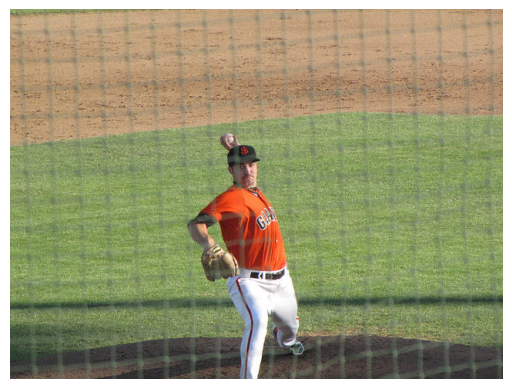

Image ID: 458752
Questions and Answers:
Q: What is this photo taken looking through?
A: net
Q: What position is this man playing?
A: pitcher
Q: What color is the players shirt?
A: orange
Q: Is this man a professional baseball player?
A: yes


In [6]:
# Estrai la prima riga del DataFrame
first_row = train_df.iloc[0]
image_id = first_row['image_id']

# Determina la cartella corretta in base al set di addestramento o validazione
if "train" in first_row['image_path']:
    image_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/train2014/'
else:
    image_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/val2014/'

# Costruisci il percorso corretto per l'immagine
image_path = os.path.join(image_dir, f"COCO_train2014_{str(image_id).zfill(12)}.jpg")

# Raccogli tutte le domande e risposte associate all'image_id
questions_answers = train_df[train_df['image_id'] == image_id][['question', 'answer']]

# Carica e mostra l'immagine
try:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Rimuovi gli assi per una visualizzazione più chiara
    plt.show()

    # Stampa le domande e risposte associate
    print(f"Image ID: {image_id}")
    print("Questions and Answers:")
    for idx, row in questions_answers.iterrows():
        print(f"Q: {row['question']}")
        print(f"A: {row['answer']}")

except FileNotFoundError:
    print(f"Image not found at path: {image_path}")

## Data Preprocessing

- Tokenizzazione: Dividiamo le domande e risposte in singoli token (parole) e rimuoviamo eventuali simboli o caratteri speciali.
- Conversione in sequenze numeriche: Assegniamo un indice numerico a ciascun token, in modo che il modello possa elaborare le sequenze di parole.
- Padding delle sequenze: Per avere lunghezze uniformi, applichiamo il padding alle sequenze, rendendole tutte della stessa lunghezza.
- Embedding: Possiamo utilizzare un embedding pre-addestrato (come GloVe o Word2Vec) o allenare un embedding direttamente sul nostro dataset.

In [7]:
# Estrai domande e risposte dai DataFrame di train e validation
train_questions = train_df['question'].values
train_answers = train_df['answer'].values
val_questions = val_df['question'].values
val_answers = val_df['answer'].values

# Imposta i parametri per la tokenizzazione e la lunghezza delle sequenze
vocab_size = 5000  # Dimensione del vocabolario
max_length = 20    # Lunghezza massima per le domande
oov_token = "<OOV>"

In [8]:
# Inizializza il tokenizzatore e adatta sui testi delle domande
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_questions)

# Converti domande e risposte in sequenze numeriche e applica il padding
train_questions_seq = tokenizer.texts_to_sequences(train_questions)
train_questions_padded = pad_sequences(train_questions_seq, maxlen=max_length, padding='post', truncating='post')

val_questions_seq = tokenizer.texts_to_sequences(val_questions)
val_questions_padded = pad_sequences(val_questions_seq, maxlen=max_length, padding='post', truncating='post')

# Tokenizza le risposte (opzionale per risposte più lunghe)
tokenizer.fit_on_texts(train_answers)
train_answers_seq = tokenizer.texts_to_sequences(train_answers)
train_answers_padded = pad_sequences(train_answers_seq, maxlen=max_length, padding='post', truncating='post')

val_answers_seq = tokenizer.texts_to_sequences(val_answers)
val_answers_padded = pad_sequences(val_answers_seq, maxlen=max_length, padding='post', truncating='post')

# Verifica del risultato
print("Sample Question (tokenized and padded):", train_questions_padded[0])
print("Sample Answer (tokenized and padded):", train_answers_padded[0])

Sample Question (tokenized and padded): [  4   3   6  28  71  99 470   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Sample Answer (tokenized and padded): [1166    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


L’output indica che il pre-processing ha funzionato correttamente. Le domande e le risposte sono state convertite in sequenze di indici numerici e quindi riempite con zeri (padding) fino alla lunghezza massima (max_length).

## Embedding Layer

Traduciamo i token numerici delle domande e risposte in vettori densi.

In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [10]:
# Parametri
embedding_dim = 64  # Dimensione dell'embedding
rnn_units = 128     # Unità per l'LSTM

# Input per le domande
question_input = Input(shape=(max_length,), name='question_input')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(question_input)
rnn_layer = LSTM(rnn_units, return_sequences=False)(embedding_layer)

# Strato denso finale per generare la risposta
output_layer = Dense(vocab_size, activation='softmax')(rnn_layer)

# Modello finale
model = Model(inputs=question_input, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Visualizza il sommario del modello
model.summary()

/home/pierluigi/Documents/virtual_ambients/objectdet/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ question_input (InputLayer)     │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 20, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5000)           │       645,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,063,816 (4.06 MB)

 Trainable params: 1,063,816 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

## Training

La funzione di perdita sparse_categorical_crossentropy si aspetta che le etichette (le risposte) abbiano una dimensione in meno rispetto all'output del modello. Attualmente, le risposte sono rappresentate come sequenze con padding di dimensione (None, 20), ma dovrebbero invece essere un singolo indice per ciascuna risposta.

Poiché stiamo utilizzando sparse_categorical_crossentropy, dobbiamo rappresentare ogni risposta come un singolo indice (cioè, la parola target della risposta) piuttosto che come una sequenza intera. In altre parole, il target (risposta) dovrebbe avere la forma (batch_size,), con ciascun valore che rappresenta l'indice di una parola.

Per risolvere il problema, possiamo:

1. Estrarre la parola principale della risposta come un singolo indice numerico.
2. Eliminare il padding dalle risposte e mantenerle come un singolo indice.

In alcuni casi train_answers_seq potrebbe contenere sequenze vuote. Questo può succedere se alcune risposte non sono state correttamente tokenizzate o sono state filtrate.
- Controllo della lunghezza: Per ogni answer in train_answers_seq e val_answers_seq, verifica se contiene almeno un elemento. Se sì, prende il primo elemento; altrimenti, imposta il valore a 0.

In [11]:
# Rimuove il padding e prende il primo token come risposta principale, se presente
train_answers_single = np.array([answer[0] if len(answer) > 0 else 0 for answer in train_answers_seq])
val_answers_single = np.array([answer[0] if len(answer) > 0 else 0 for answer in val_answers_seq])

# Parametri di addestramento
batch_size = 64  # Numero di campioni per batch
epochs = 10      # Numero di epoche di addestramento

# Esegui l'addestramento con le risposte aggiornate
history = model.fit(
    train_questions_padded,         # Domande di training
    train_answers_single,           # Risposte singole di training
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_questions_padded, val_answers_single)  # Dati di validazione
)

Epoch 1/10
6934/6934 ━━━━━━━━━━━━━━━━━━━━ 461s 66ms/step - accuracy: 0.2285 - loss: 4.1149 - val_accuracy: 0.2993 - val_loss: 2.7975
Epoch 2/10
6934/6934 ━━━━━━━━━━━━━━━━━━━━ 514s 74ms/step - accuracy: 0.3095 - loss: 2.6833 - val_accuracy: 0.3313 - val_loss: 2.5332
Epoch 3/10
6934/6934 ━━━━━━━━━━━━━━━━━━━━ 535s 77ms/step - accuracy: 0.3341 - loss: 2.4322 - val_accuracy: 0.3414 - val_loss: 2.4256
Epoch 4/10
6934/6934 ━━━━━━━━━━━━━━━━━━━━ 541s 78ms/step - accuracy: 0.3480 - loss: 2.2971 - val_accuracy: 0.3473 - val_loss: 2.3668
Epoch 5/10
6934/6934 ━━━━━━━━━━━━━━━━━━━━ 663s 96ms/step - accuracy: 0.3568 - loss: 2.2069 - val_accuracy: 0.3577 - val_loss: 2.3374
Epoch 6/10
6934/6934 ━━━━━━━━━━━━━━━━━━━━ 685s 99ms/step - accuracy: 0.3646 - loss: 2.1371 - val_accuracy: 0.3568 - val_loss: 2.3196
Epoch 7/10
6934/6934 ━━━━━━━━━━━━━━━━━━━━ 409s 59ms/step - accuracy: 0.3731 - loss: 2.0812 - val_accuracy: 0.3588 - val_loss: 2.3149
Epoch 8/10
6934/6934 ━━━━━━━━━━━━━━━━━━━━ 396s 57ms/step - accuracy: 

Le ragioni per cui l'accuratezza è ancora bassa possono essere molteplici, specialmente in un task di Visual Question Answering (VQA), che è complesso di per sé. Ecco alcune possibili cause per la tua attuale accuratezza:

Limiti del Modello (LSTM):

Un modello LSTM può essere limitato nel catturare la complessità delle interazioni tra testo e immagini in un task VQA. Le LSTM non gestiscono al meglio contesti complessi e non sono progettate specificamente per comprendere informazioni visive.
Mancanza di Feature Visive:

In questo caso, stiamo usando solo l’input di testo. Senza un'integrazione con feature estratte dalle immagini (ad esempio, attraverso una CNN pre-addestrata come ResNet), il modello potrebbe faticare a rispondere accuratamente a domande visive.
Dimensione del Vocabolario e Embedding:

L’attuale dimensione del vocabolario e del layer di embedding potrebbe essere limitante per la varietà delle domande e risposte nel dataset VQA, che spesso include termini molto specifici. Un embedding più grande o un vocabolario più ampio potrebbe aiutare.
Dati di Addestramento:

Anche se hai un set di dati ampio, il task di VQA è difficile e richiede spesso un numero elevato di epoche per migliorare sensibilmente l'accuratezza.
Struttura della Rete:

L’architettura corrente è semplice: un singolo livello LSTM con un’uscita densa. Una struttura più complessa (ad esempio, più layer LSTM o un Transformer) potrebbe modellare meglio la struttura delle domande.

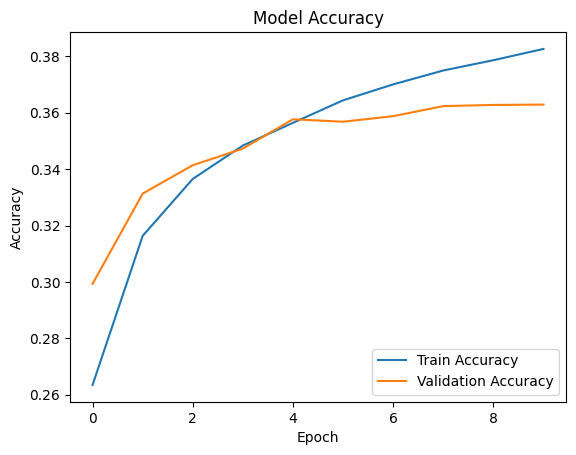

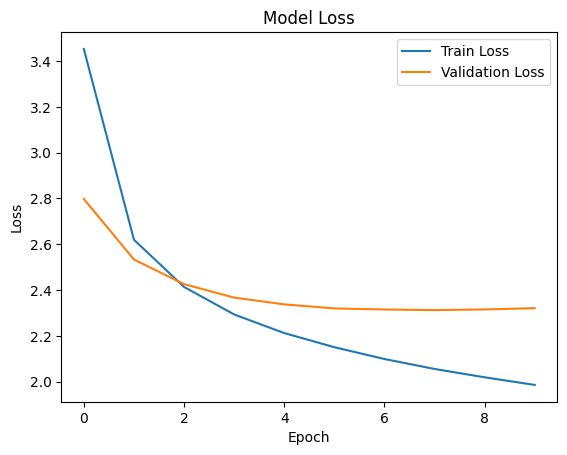

In [12]:
# Grafico dell'accuratezza
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()

# Grafico della perdita
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()


## Model Testing

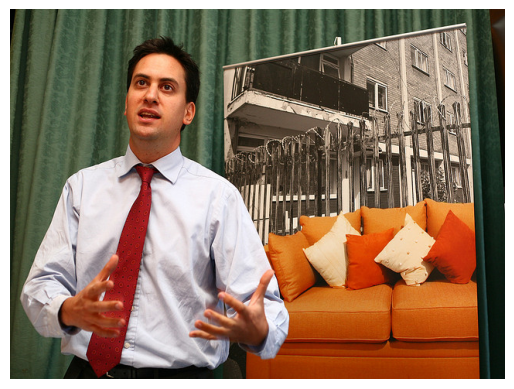

Question: Is this man wearing a hat?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
Predicted Answer: no
Correct Answer: no


In [ ]:
# Scegli una domanda casuale dal set di validazione
random_index = random.randint(0, len(val_questions_padded) - 1)
test_question = val_questions_padded[random_index]
test_image_id = val_df.iloc[random_index]['image_id']
test_image_path = val_df.iloc[random_index]['image_path']

if "val2014" in test_image_path:
    image_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/val2014/'
else:
    image_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/train2014/'
image_path = f"{image_dir}COCO_val2014_{str(test_image_id).zfill(12)}.jpg"

# Visualizza l'immagine associata
try:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"Image not found at path: {image_path}")

# Recupera la domanda originale e stampa la risposta predetta
original_question = val_df.iloc[random_index]['question']
print(f"Question: {original_question}")

# Prevedi la risposta
predicted_answer = model.predict(test_question.reshape(1, -1))
predicted_index = predicted_answer.argmax()  # Trova l'indice della parola con probabilità più alta

# Recupera la parola dalla tokenizzazione inversa
predicted_word = tokenizer.index_word.get(predicted_index, "Unknown")
print(f"Predicted Answer: {predicted_word}")

# Confronta con la risposta corretta
correct_answer = val_df.iloc[random_index]['answer']
print(f"Correct Answer: {correct_answer}")


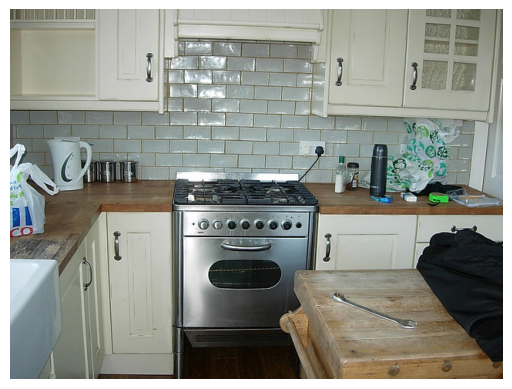

Question: What room is this?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Answer: kitchen
Correct Answer: kitchen


In [16]:
# Scegli una domanda casuale dal set di validazione
random_index = random.randint(0, len(val_questions_padded) - 1)
test_question = val_questions_padded[random_index]
test_image_id = val_df.iloc[random_index]['image_id']
test_image_path = val_df.iloc[random_index]['image_path']

if "val2014" in test_image_path:
    image_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/val2014/'
else:
    image_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/train2014/'
image_path = f"{image_dir}COCO_val2014_{str(test_image_id).zfill(12)}.jpg"

# Visualizza l'immagine associata
try:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"Image not found at path: {image_path}")

# Recupera la domanda originale e stampa la risposta predetta
original_question = val_df.iloc[random_index]['question']
print(f"Question: {original_question}")

# Prevedi la risposta
predicted_answer = model.predict(test_question.reshape(1, -1))
predicted_index = predicted_answer.argmax()  # Trova l'indice della parola con probabilità più alta

# Recupera la parola dalla tokenizzazione inversa
predicted_word = tokenizer.index_word.get(predicted_index, "Unknown")
print(f"Predicted Answer: {predicted_word}")

# Confronta con la risposta corretta
correct_answer = val_df.iloc[random_index]['answer']
print(f"Correct Answer: {correct_answer}")
